In [1]:
%matplotlib inline

In [2]:
#Set model to freely swim
use_free_move = False

# Importing Libraries

Importing libraries for script

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import idealab_tools.units
import scipy.optimize
from matplotlib import animation, rc
from IPython.display import HTML


system = System()
pynamics.set_system(__name__,system)


#Setting Unit scaling for model
idealab_tools.units.Unit.set_scaling(m=1000) #units mm
idealab_tools.units.Unit.set_scaling(kg=1000) #units g
density_u = idealab_tools.units.Unit(kg = 1,m = -3)
area_u = idealab_tools.units.Unit(m = 2)
rotational_damping = idealab_tools.units.Unit(N = 1,m= 1,rad= -1)

# Constants of System

In this block of code we are defining all the constants of our system that we will use for our simulation

In [4]:
#Defining Constants of System
seg_len = 0.005  #segment mass
seg_mass = 0.005 #segment mass 
seg_h = 0.02 #segment height
seg_th = 0.005 #segment thickness

#Set segment lengths
lA = Constant(seg_len*idealab_tools.units.length,'lA',system)
lB = Constant(seg_len*idealab_tools.units.length,'lB',system)
lC = Constant(seg_len*idealab_tools.units.length,'lC',system)
lD = Constant(seg_len*idealab_tools.units.length,'lD',system)
lE = Constant(seg_len*idealab_tools.units.length,'lE',system)
lF = Constant(seg_len*idealab_tools.units.length,'lF',system)
lG = Constant(seg_len*idealab_tools.units.length,'lG',system) #Tail segment
lP = Constant(seg_len*5*idealab_tools.units.length,'lP',system) #Constrained length

#Set masses
mA = Constant(seg_mass*idealab_tools.units.mass,'mA',system)
mB = Constant(seg_mass*idealab_tools.units.mass,'mB',system)
mC = Constant(seg_mass*idealab_tools.units.mass,'mC',system)
mD = Constant(seg_mass*idealab_tools.units.mass,'mD',system)
mE = Constant(seg_mass*idealab_tools.units.mass,'mE',system)
mF = Constant(seg_mass*idealab_tools.units.mass,'mF',system)
mG = Constant(seg_mass*idealab_tools.units.mass,'mF',system)


b = Constant(1e-1*rotational_damping,'b',system)
k = Constant(1e-1*idealab_tools.units.rotational_stiffness,'k',system)
area = Constant(seg_len*seg_h*area_u,'area',system)
rho = Constant(998*density_u,'rho',system)

freq = Constant(0.5,'freq',system)
amp = Constant(44*pi/180,'amp',system)
torque = Constant(1e0,'torque',system)

Ix = 1/12*seg_mass*(seg_h**2 + seg_th**2)
Iy = 1/12*seg_mass*(seg_h**2 + seg_len**2)
Iz = 1/12*seg_mass*(seg_len**2 + seg_th**2)

Ixx_A = Constant(Ix*idealab_tools.units.inertia,'Ixx_A',system)
Iyy_A = Constant(Iy*idealab_tools.units.inertia,'Iyy_A',system)
Izz_A = Constant(Iz*idealab_tools.units.inertia,'Izz_A',system)
Ixx_B = Constant(Ix*idealab_tools.units.inertia,'Ixx_B',system)
Iyy_B = Constant(Iy*idealab_tools.units.inertia,'Iyy_B',system)
Izz_B = Constant(Iz*idealab_tools.units.inertia,'Izz_B',system)
Ixx_C = Constant(Ix*idealab_tools.units.inertia,'Ixx_C',system)
Iyy_C = Constant(Iy*idealab_tools.units.inertia,'Iyy_C',system)
Izz_C = Constant(Iz*idealab_tools.units.inertia,'Izz_C',system)
Ixx_D = Constant(Ix*idealab_tools.units.inertia,'Ixx_D',system)
Iyy_D = Constant(Iy*idealab_tools.units.inertia,'Iyy_D',system)
Izz_D = Constant(Iz*idealab_tools.units.inertia,'Izz_D',system)
Ixx_E = Constant(Ix*idealab_tools.units.inertia,'Ixx_E',system)
Iyy_E = Constant(Iy*idealab_tools.units.inertia,'Iyy_E',system)
Izz_E = Constant(Iz*idealab_tools.units.inertia,'Izz_E',system)
Ixx_F = Constant(Ix*idealab_tools.units.inertia,'Ixx_F',system)
Iyy_F = Constant(Iy*idealab_tools.units.inertia,'Iyy_F',system)
Izz_F = Constant(Iz*idealab_tools.units.inertia,'Izz_F',system)
Ixx_G = Constant(Ix*idealab_tools.units.inertia,'Ixx_G',system)
Iyy_G = Constant(Iy*idealab_tools.units.inertia,'Iyy_G',system)
Izz_G = Constant(Iz*idealab_tools.units.inertia,'Izz_G',system)

In [5]:
#Set integration tolerance
tol = 1e-6

In [6]:
#Set simulation run time
fps = 30/(1*idealab_tools.units.time)
tinitial = 0*idealab_tools.units.time
tfinal = 5*idealab_tools.units.time
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)

if use_free_move:
    x,x_d,x_dd = Differentiable('x',system)
    y,y_d,y_dd = Differentiable('y',system)

In [8]:
#set initial conditions
initialvalues = {}
initialvalues[qA]=70*pi/180*idealab_tools.units.radian
initialvalues[qA_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qB]=30*pi/180*idealab_tools.units.radian
initialvalues[qB_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qC]=0*pi/180*idealab_tools.units.radian
initialvalues[qC_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qD]=0*pi/180*idealab_tools.units.radian
initialvalues[qD_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qE]=-10*pi/180*idealab_tools.units.radian
initialvalues[qE_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qF]=-40*pi/180*idealab_tools.units.radian
initialvalues[qF_d]=0*pi/180*idealab_tools.units.rotational_speed
initialvalues[qG]=0*pi/180*idealab_tools.units.radian
initialvalues[qG_d]=0*pi/180*idealab_tools.units.rotational_speed

if use_free_move:
    initialvalues[x]=0*pi/180*idealab_tools.units.radian
    initialvalues[x_d]=0*pi/180*idealab_tools.units.rotational_speed
    initialvalues[y]=0*pi/180*idealab_tools.units.radian
    initialvalues[y_d]=0*pi/180*idealab_tools.units.rotational_speed

statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
#Frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
G = Frame('G',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(N,[0,0,1],qB,system)
C.rotate_fixed_axis(N,[0,0,1],qC,system)
D.rotate_fixed_axis(N,[0,0,1],qD,system)
E.rotate_fixed_axis(N,[0,0,1],qE,system)
F.rotate_fixed_axis(N,[0,0,1],qF,system)
G.rotate_fixed_axis(N,[0,0,1],qG,system)

# Defining Vectors

In this section of code we are defining all the position and center of mass vecotors. Additionally we are calculating angular velocity of each frame and the respective linear velocities at the center of mass. We also build each body of the system in this section.

In [10]:
#Vectors

if use_free_move:
    pNA=x*N.x + y*N.y + 0*N.z
    pP = lP*N.x + pNA
else:
    pNA=0*N.x + 0*N.y + 0*N.z
    pP = lP*N.x
    
pAB= pNA + lA*A.x
pBC = pAB + lB*B.x
pCD = pBC + lC*C.x
pDE = pCD + lD*D.x
pEF = pDE + lE*E.x
pFG = pEF + lF*F.x
pGtip = pFG + lG*G.x

#Center of Mass
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x
pDcm=pCD+lD/2*D.x
pEcm=pDE+lE/2*E.x
pFcm=pEF+lF/2*F.x
pGcm=pFG+lF/2*G.x

#Angular Velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B) 
wBC = B.get_w_to(C)
wCD = C.get_w_to(D) 
wDE = D.get_w_to(E)
wEF = E.get_w_to(F)
wFG = F.get_w_to(G)

#Velocities 
vA=pAcm.time_derivative()
vB=pBcm.time_derivative()
vC=pCcm.time_derivative()
vD=pDcm.time_derivative()
vE=pEcm.time_derivative()
vF=pFcm.time_derivative()
vGtip=pGtip.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)
BodyG = Body('BodyG',G,pGcm,mG,IG,system)

# Adding Forces

In this section of code we are adding the aerodynamic, spring, and damping forces in the system. The damping and spring values will be calculated experimentally

In [11]:
#Forces
#system.addforce(torque*sympy.cos(freq*2*pi*system.t)*A.z,wNA)

#Aerodynamic Forces
f_aero_Ay = rho * vA.length()*(vA.dot(A.y)) * area * A.y
f_aero_By = rho * vB.length()*(vB.dot(B.y)) * area * B.y
f_aero_Cy = rho * vC.length()*(vC.dot(C.y)) * area * C.y
f_aero_Dy = rho * vD.length()*(vD.dot(D.y)) * area * D.y
f_aero_Ey = rho * vE.length()*(vE.dot(E.y)) * area * E.y
f_aero_Fy = rho * vF.length()*(vF.dot(F.y)) * area * F.y
f_aero_Gy = rho * vGtip.length()*(vGtip.dot(G.y)) * area * G.y

system.addforce(-f_aero_Ay,vA)
system.addforce(-f_aero_By,vB)
system.addforce(-f_aero_Cy,vC)
system.addforce(-f_aero_Dy,vD)
system.addforce(-f_aero_Ey,vE)
system.addforce(-f_aero_Fy,vF)
system.addforce(-f_aero_Gy,vGtip)

#Damping Forces
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wFG,wFG)

#Spring Force (Torsion)
system.add_spring_force1(k,(qA)*N.z,wNA) 
system.add_spring_force1(k,(qB-qA)*N.z,wAB)
system.add_spring_force1(k,(qC-qB)*N.z,wBC)
system.add_spring_force1(k,(qD-qC)*N.z,wCD) 
system.add_spring_force1(k,(qE-qD)*N.z,wDE)
system.add_spring_force1(k,(qF-qE)*N.z,wEF)
system.add_spring_force1(k,(qG-qF)*N.z,wFG)

(<pynamics.force.Force at 0x20a9eb3dfa0>,
 <pynamics.spring.Spring at 0x20a9eb3da30>)

In [12]:
#Constraints for initial condition

eq = []

eq.append(pFG-pP)
    
eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))

2022-03-22 10:15:11,886 - pynamics.output - INFO - calculating outputs
2022-03-22 10:15:11,886 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

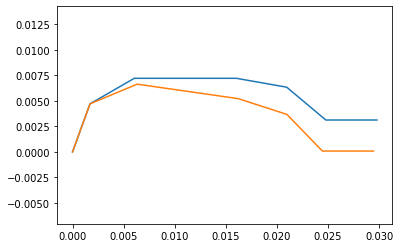

In [13]:
#Solve for Intial Conditions
if use_free_move:
    qi = [qA,x,y]
else:  
    qi = [qA]

c=KinematicConstraint(eq_scalar)

variables = [qB,qC,qD,qE,qF,qG]

constant_states = list(set(system.get_q(0))-set(variables))
constants = system.constant_values.copy()

for key in constant_states:
    constants[key] = initialvalues[key] 
guess = [initialvalues[item] for item in variables]

result = c.solve_numeric(variables,guess,constants)

ini = []
for item in system.get_state_variables():
    if item in variables:
        ini.append(result[item])
    else:
        ini.append(initialvalues[item])
        
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFG,pGtip]
        
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),[0,1])
points.plot_time()

In [14]:
#Adding Dynamic Constraints

#Position of motor limits
pos = amp*sympy.cos(freq*2*pi*system.t)

eq = []
eq.append(pFG-pP)
eq.append(pos*N.z-qA*N.z)

eq_d = []
eq_d = [item.time_derivative() for item in eq]

eq_dd = []
eq_dd = [item.time_derivative() for item in eq_d]

eq_scalar_dd = []
eq_scalar_dd.append(eq[0].dot(N.x))
eq_scalar_dd.append(eq[0].dot(N.y))
eq_scalar_dd.append(eq[1].dot(N.z))

#system.add_constraint(AccelerationConstraint(eq_scalar_dd))

2022-03-22 10:15:12,147 - pynamics.system - INFO - getting dynamic equations
2022-03-22 10:15:13,720 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-22 10:15:18,672 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-22 10:15:19,349 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-22 10:15:19,357 - pynamics.system - INFO - calculating function for lambdas
2022-03-22 10:15:19,381 - pynamics.integration - INFO - beginning integration
2022-03-22 10:15:19,381 - pynamics.system - INFO - integration at time 0000.00
C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
2022-03-22 10:15:19,420 - pynamics.integration - INFO - finished integration


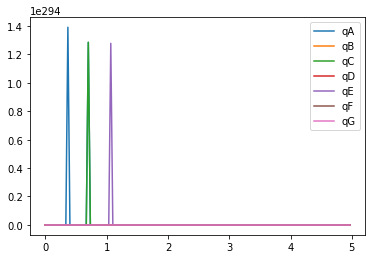

In [15]:
#Solve model and plot angles

f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':system.constant_values},))

plt.figure()
artists = plt.plot(t,states[:,:7])
plt.legend(artists,['qA','qB','qC','qD','qE','qF','qG'])

2022-03-22 10:15:19,591 - pynamics.output - INFO - calculating outputs
2022-03-22 10:15:19,598 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

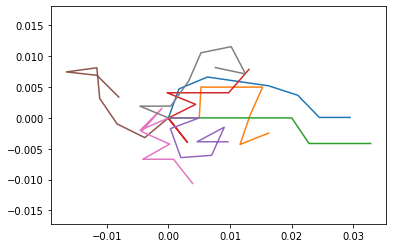

In [16]:
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFG,pGtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

In [17]:
#Constraint Forces

lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
plt.figure()
plt.plot(t, lambda2)

<lambdifygenerated-4>:2: RuntimeWarning: overflow encountered in double_scalars
  return (array([[-0.125*area*lA**2*rho*qA_d*sqrt(lA**2*qA_d**2) - area*lA*rho*(lA*qA_d*sin(qA)*sin(qB) + lA*qA_d*cos(qA)*cos(qB) + (1/2)*lB*qB_d)*sqrt(lA**2*qA_d**2 + lA*lB*qA_d*qB_d*sin(qA)*sin(qB) + lA*lB*qA_d*qB_d*cos(qA)*cos(qB) + (1/4)*lB**2*qB_d**2)*sin(qA)*sin(qB) - area*lA*rho*(lA*qA_d*sin(qA)*sin(qB) + lA*qA_d*cos(qA)*cos(qB) + (1/2)*lB*qB_d)*sqrt(lA**2*qA_d**2 + lA*lB*qA_d*qB_d*sin(qA)*sin(qB) + lA*lB*qA_d*qB_d*cos(qA)*cos(qB) + (1/4)*lB**2*qB_d**2)*cos(qA)*cos(qB) - area*lA*rho*(lA*qA_d*sin(qA)*sin(qC) + lA*qA_d*cos(qA)*cos(qC) + lB*qB_d*sin(qB)*sin(qC) + lB*qB_d*cos(qB)*cos(qC) + (1/2)*lC*qC_d)*sqrt(lA**2*qA_d**2 + 2*lA*lB*qA_d*qB_d*sin(qA)*sin(qB) + 2*lA*lB*qA_d*qB_d*cos(qA)*cos(qB) + lA*lC*qA_d*qC_d*sin(qA)*sin(qC) + lA*lC*qA_d*qC_d*cos(qA)*cos(qC) + lB**2*qB_d**2 + lB*lC*qB_d*qC_d*sin(qB)*sin(qC) + lB*lC*qB_d*qC_d*cos(qB)*cos(qC) + (1/4)*lC**2*qC_d**2)*sin(qA)*sin(qC) - area*lA*rho*(lA*qA_d*

ValueError: array must not contain infs or NaNs

In [ ]:
#Energy Plot

#KE = system.get_KE()
#PE = system.getPESprings()
#energy_output = Output([KE-PE],system)
#energy_output.calc(states,t)
#energy_output.plot_time(t)

In [ ]:
#Plotting Motion of Tail

plt.plot(y[:,7,0],y[:,7,1])
plt.axis('equal')
plt.title('Position of Tail')
plt.xlabel('Position X (m)')
plt.ylabel('Position Y (m)')

In [ ]:
if use_free_move:
    points_output.animate(fps = fps,movie_name = 'dynamics_free_swimming.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
else:
    points_output.animate(fps = fps,movie_name = 'dynamics.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
    
HTML(points_output.anim.to_html5_video())

In [ ]:
idealab_tools.units.linear_damping